# Imports

In [25]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import os
import random
from sklearn.metrics import classification_report

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.20.0
NumPy version:      2.3.5

⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU


# 1. Data Exploration & PreProcessing

## 1.1 Load Data

In [26]:
train_dir = '../data/seg_train/seg_train'
test_dir = '../data/seg_test/seg_test'

print("Dataset structure:")
for root, dirs, files in os.walk('../data/'):
    level = root.replace('../data/', '').count(os.sep)
    indent = '  ' * level
    if level <= 2: # Keep output clean
        print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")

IMG_SIZE = 150  # Native resolution for Intel dataset
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Use categorical for 6 classes
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Test set (separate folder)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"\nClasses found: {class_names}")

Dataset structure:
/ (0 files)
seg_pred/ (0 files)
  seg_pred/ (7301 files)
seg_test/ (0 files)
  seg_test/ (0 files)
    buildings/ (437 files)
    forest/ (474 files)
    glacier/ (553 files)
    mountain/ (525 files)
    sea/ (510 files)
    street/ (501 files)
seg_train/ (0 files)
  seg_train/ (0 files)
    buildings/ (2191 files)
    forest/ (2271 files)
    glacier/ (2404 files)
    mountain/ (2512 files)
    sea/ (2274 files)
    street/ (2382 files)
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.

Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 1.2 Visualize Sample

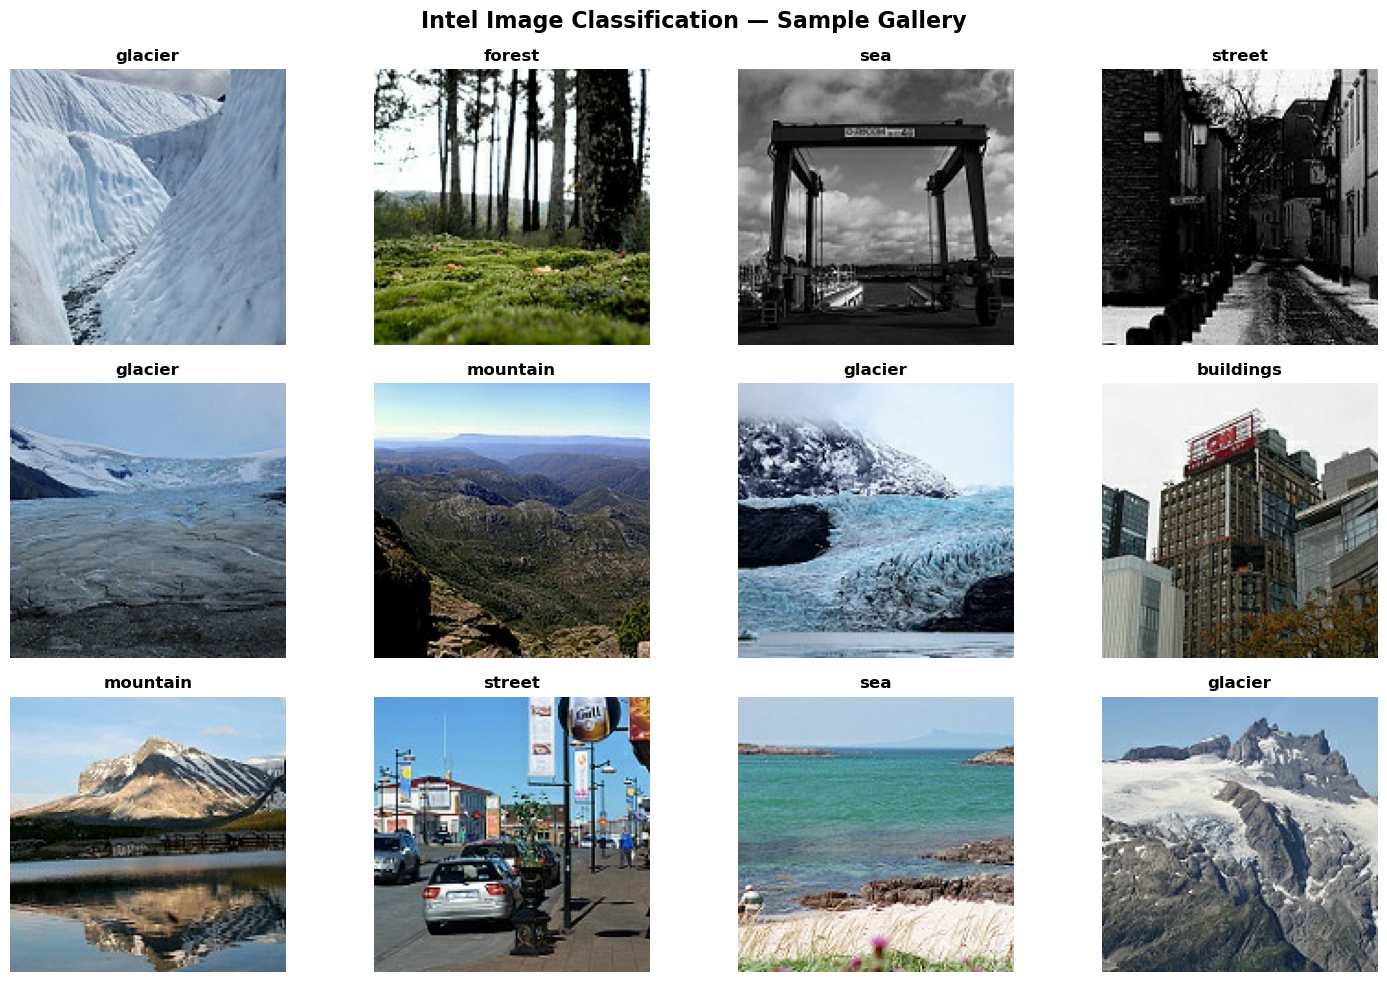

In [27]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(12): # Show 12 images
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx], fontsize=12, fontweight='bold')
        plt.axis('off')

plt.suptitle('Intel Image Classification — Sample Gallery', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 1.3 Data Analysis

In [28]:
# Check batch properties and data format
for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Pixel range: [{images.numpy().min():.0f}, {images.numpy().max():.0f}]")
    print(f"Flattened size: {150*150*3:,} features")

# Optimize data pipeline for training performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("Data pipeline optimized for training")


# DATASET ANALYSIS - Class Distribution & Quality Check
print("\n" + "="*50)
print("DATASET ANALYSIS")
print("="*50)

# Count images per class
print("\n Class Distribution:")
class_counts = {}
for images, labels in train_ds.unbatch().batch(5000):
    for label in labels:
        idx = np.argmax(label.numpy())
        class_counts[class_names[idx]] = class_counts.get(class_names[idx], 0) + 1

# Display distribution
total = sum(class_counts.values())
for name in class_names:
    count = class_counts.get(name, 0)
    print(f"  {name:12s}: {count:4d} images ({count/total*100:5.1f}%)")

# Check for class imbalance
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count
print(f"\n  Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("Moderate class imbalance")
else:
    print("Classes are relatively balanced")

# Verify dataset sizes
print(f"\n Dataset Sizes:")
train_size = len(list(train_ds.unbatch()))
val_size = len(list(val_ds.unbatch()))
test_size = len(list(test_ds.unbatch()))
print(f"  Training:   {train_size:,} images")
print(f"  Validation: {val_size:,} images")
print(f"  Test:       {test_size:,} images")

Batch shape: (32, 150, 150, 3)
Pixel range: [0, 255]
Flattened size: 67,500 features
Data pipeline optimized for training

DATASET ANALYSIS

 Class Distribution:
  buildings   : 1761 images ( 15.7%)
  forest      : 1835 images ( 16.3%)
  glacier     : 1931 images ( 17.2%)
  mountain    : 1998 images ( 17.8%)
  sea         : 1797 images ( 16.0%)
  street      : 1906 images ( 17.0%)

  Imbalance ratio: 1.13:1
Classes are relatively balanced

 Dataset Sizes:
  Training:   11,228 images
  Validation: 2,806 images
  Test:       3,000 images


# 2. Baseline CNN (No Augmentation)

In [29]:
def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n📊 Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   ⚠️  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   ⚡ Moderate gap — some overfitting")
    else:
        print(f"   ✅ Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    """Show model predictions on sample images for multi-class classification."""
    plt.figure(figsize=(16, 8)) # Increased height for 2 rows
    
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            pred_label = np.argmax(predictions[i])
            pred_prob = predictions[i][pred_label]
            
            true_label = np.argmax(labels[i])
            
            color = 'green' if pred_label == true_label else 'red'
            
            plt.title(f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                      fontsize=10, color=color, fontweight='bold')
            plt.axis('off')
            
    plt.suptitle('Intel Scene Predictions (Green=Correct, Red=Wrong)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

In [30]:
model_intel = models.Sequential([
    # Rescaling layer (normalize pixels to 0-1)
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # Note: 6 neurons for 6 classes, 'softmax' for multi-class probability
    layers.Dense(6, activation='softmax') 
])

# Display the architecture
model_intel.summary()
model_intel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Model compiled for Multi-class (6 classes)")

C:\Users\henry\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Model compiled for Multi-class (6 classes)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.8774 - loss: 0.3372 - val_accuracy: 0.8200 - val_loss: 0.5422
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 279ms/step - accuracy: 0.9184 - loss: 0.2346 - val_accuracy: 0.8143 - val_loss: 0.6057
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 279ms/step - accuracy: 0.9483 - loss: 0.1490 - val_accuracy: 0.8097 - val_loss: 0.8100
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 280ms/step - accuracy: 0.9680 - loss: 0.0974 - val_accuracy: 0.7944 - val_loss: 0.8556
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 283ms/step - accuracy: 0.9762 - loss: 0.0749 - val_accuracy: 0.7962 - val_loss: 1.0104
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 278ms/step - accuracy: 0.9858 - loss: 0.0486 - val_accuracy: 0.7748 - val_loss: 1.2278
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 272ms/step - accuracy: 0.9880 - loss: 0.0399 - val_accuracy: 0.7830 - val_loss: 1.2122
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 271ms/step - accuracy: 0.9822 - loss: 

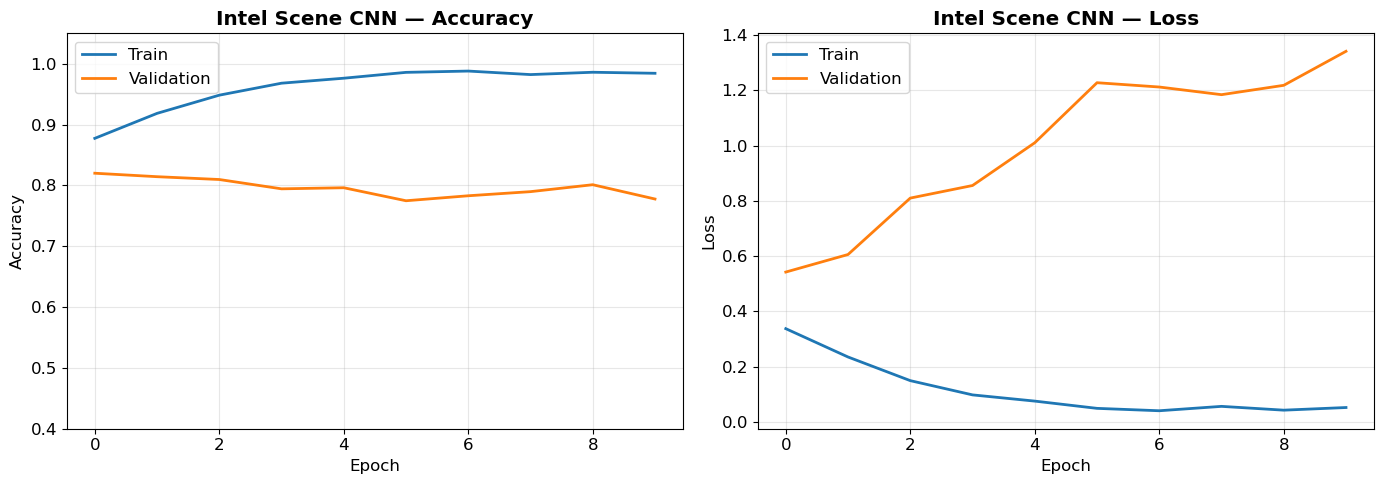


📊 Final Results:
   Train Accuracy:      0.9843 (98.4%)
   Validation Accuracy: 0.7776 (77.8%)
   Gap (overfit check): 0.2067 (20.7%)
   ⚠️  Large gap — model is OVERFITTING


In [40]:
EPOCHS = 10

history_intel = model_intel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Plot training curves using your helper function
plot_training_curves(history_intel, title='Intel Scene CNN')

### Discussion
- Tried 50, 25, 15, 10, 5: They all overfit..
- Epoch 3 gave the good generalization


Detailed Classification Report:
              precision    recall  f1-score   support

   buildings       0.75      0.72      0.73       437
      forest       0.98      0.86      0.92       474
     glacier       0.80      0.66      0.72       553
    mountain       0.78      0.64      0.70       525
         sea       0.67      0.87      0.76       510
      street       0.73      0.89      0.80       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



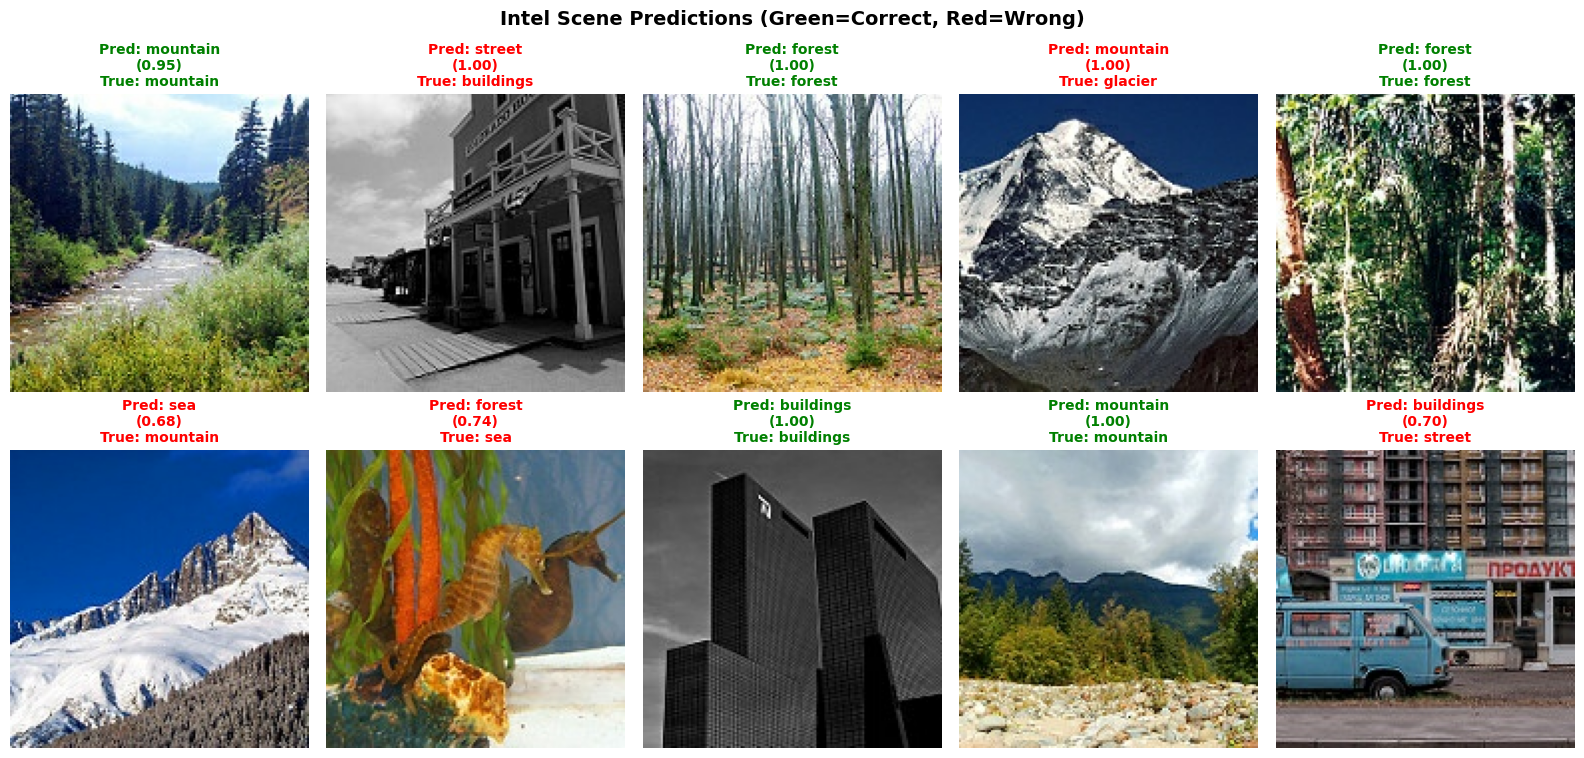


BASELINE MODEL - SUMMARY
Training Accuracy:   0.9843 (98.4%)
Validation Accuracy: 0.7776 (77.8%)
Test Accuracy:       0.7720 (77.2%)
Overfitting Gap:     0.2067 (20.7%)
Weighted F1-Score:   0.7711


In [41]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_intel.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate detailed classification report (precision, recall, F1 per class)
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Show visual predictions (green=correct, red=wrong)
show_predictions(model_intel, test_ds, class_names)

# Calculate and store baseline metrics for later comparison
baseline_train_acc = history_intel.history['accuracy'][-1]
baseline_val_acc = history_intel.history['val_accuracy'][-1]
baseline_test_acc = sum([1 for t, p in zip(y_true, y_pred) if t == p]) / len(y_true)

# Calculate weighted F1-score
from sklearn.metrics import f1_score
baseline_f1 = f1_score(y_true, y_pred, average='weighted')

# Display baseline model summary
print("\n" + "="*50)
print("BASELINE MODEL - SUMMARY")
print("="*50)
print(f"Training Accuracy:   {baseline_train_acc:.4f} ({baseline_train_acc*100:.1f}%)")
print(f"Validation Accuracy: {baseline_val_acc:.4f} ({baseline_val_acc*100:.1f}%)")
print(f"Test Accuracy:       {baseline_test_acc:.4f} ({baseline_test_acc*100:.1f}%)")
print(f"Overfitting Gap:     {(baseline_train_acc - baseline_val_acc):.4f} ({(baseline_train_acc - baseline_val_acc)*100:.1f}%)")
print(f"Weighted F1-Score:   {baseline_f1:.4f}")
print("="*50)

# 3. Improved CNN (With Augmentation)


In [33]:
inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = inp
conv_outputs = []
conv_names = []
for layer in model_intel.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")

feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)


  conv2d_15: output shape = (None, 148, 148, 32)
  conv2d_16: output shape = (None, 72, 72, 64)
  conv2d_17: output shape = (None, 34, 34, 128)


In [49]:
# Create data augmentation pipeline
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # 10% rotation range 
    layers.RandomZoom(0.05),     # 5% zoom range
])

model_improved = models.Sequential([
    # Input & Augmentation
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1), # Regularization
    
    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15), # Regularization (reduced from 0.3)
    
    # Classification Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2), 
    layers.Dense(6, activation='softmax') # Multi-class output
])

# Compile for 6 classes
model_improved.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_improved.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,403,462 (20.61 MB)

 Trainable params: 5,403,014 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 290s 818ms/step - accuracy: 0.4802 - loss: 1.8331 - val_accuracy: 0.4312 - val_loss: 2.1033
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 287s 817ms/step - accuracy: 0.5714 - loss: 1.1762 - val_accuracy: 0.5627 - val_loss: 1.1707
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 284s 809ms/step - accuracy: 0.6205 - loss: 1.0366 - val_accuracy: 0.6365 - val_loss: 0.9577
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 302s 859ms/step - accuracy: 0.6391 - loss: 0.9846 - val_accuracy: 0.5221 - val_loss: 1.3619
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 333s 948ms/step - accuracy: 0.6559 - loss: 0.9263 - val_accuracy: 0.4993 - val_loss: 1.7335
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.6707 - loss: 0.9090 - val_accuracy: 0.5556 - val_loss: 1.1734
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.6867 - loss: 0.8432 - val_accuracy: 0.6372 - val_loss: 1.0815
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.7011 - loss: 0.

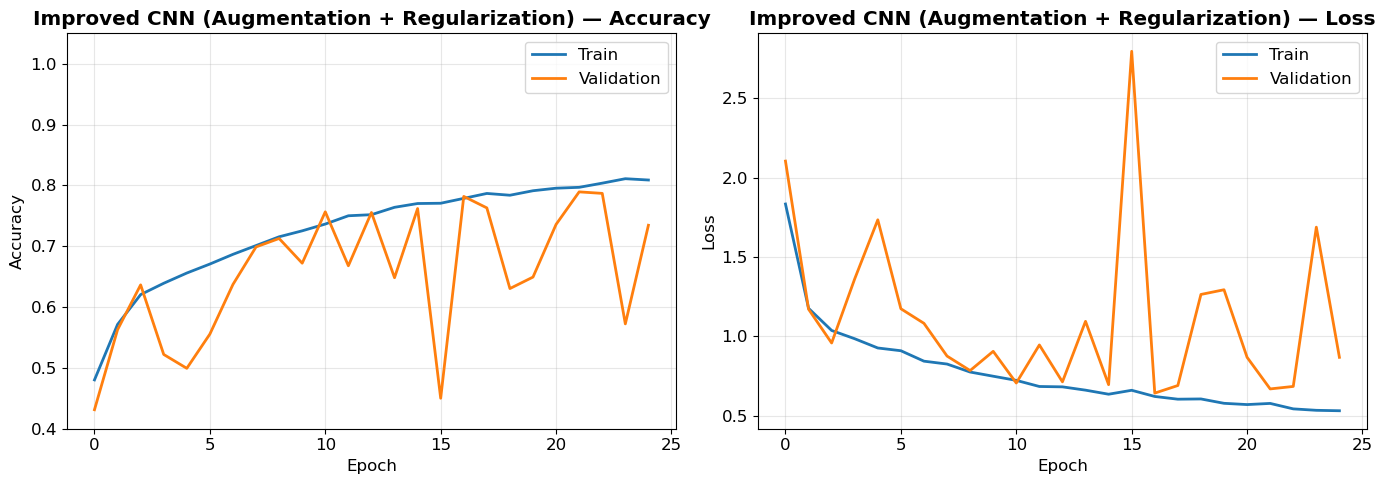


📊 Final Results:
   Train Accuracy:      0.8089 (80.9%)
   Validation Accuracy: 0.7345 (73.4%)
   Gap (overfit check): 0.0744 (7.4%)
   ⚡ Moderate gap — some overfitting


In [50]:
EPOCHS = 25

history_improved = model_improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Plot training curves
plot_training_curves(history_improved, title='Improved CNN (Augmentation + Regularization)')


Detailed Classification Report:
              precision    recall  f1-score   support

   buildings       0.46      0.91      0.61       437
      forest       0.92      0.94      0.93       474
     glacier       0.88      0.53      0.66       553
    mountain       0.75      0.67      0.71       525
         sea       0.80      0.77      0.78       510
      street       0.87      0.64      0.74       501

    accuracy                           0.73      3000
   macro avg       0.78      0.74      0.74      3000
weighted avg       0.79      0.73      0.74      3000



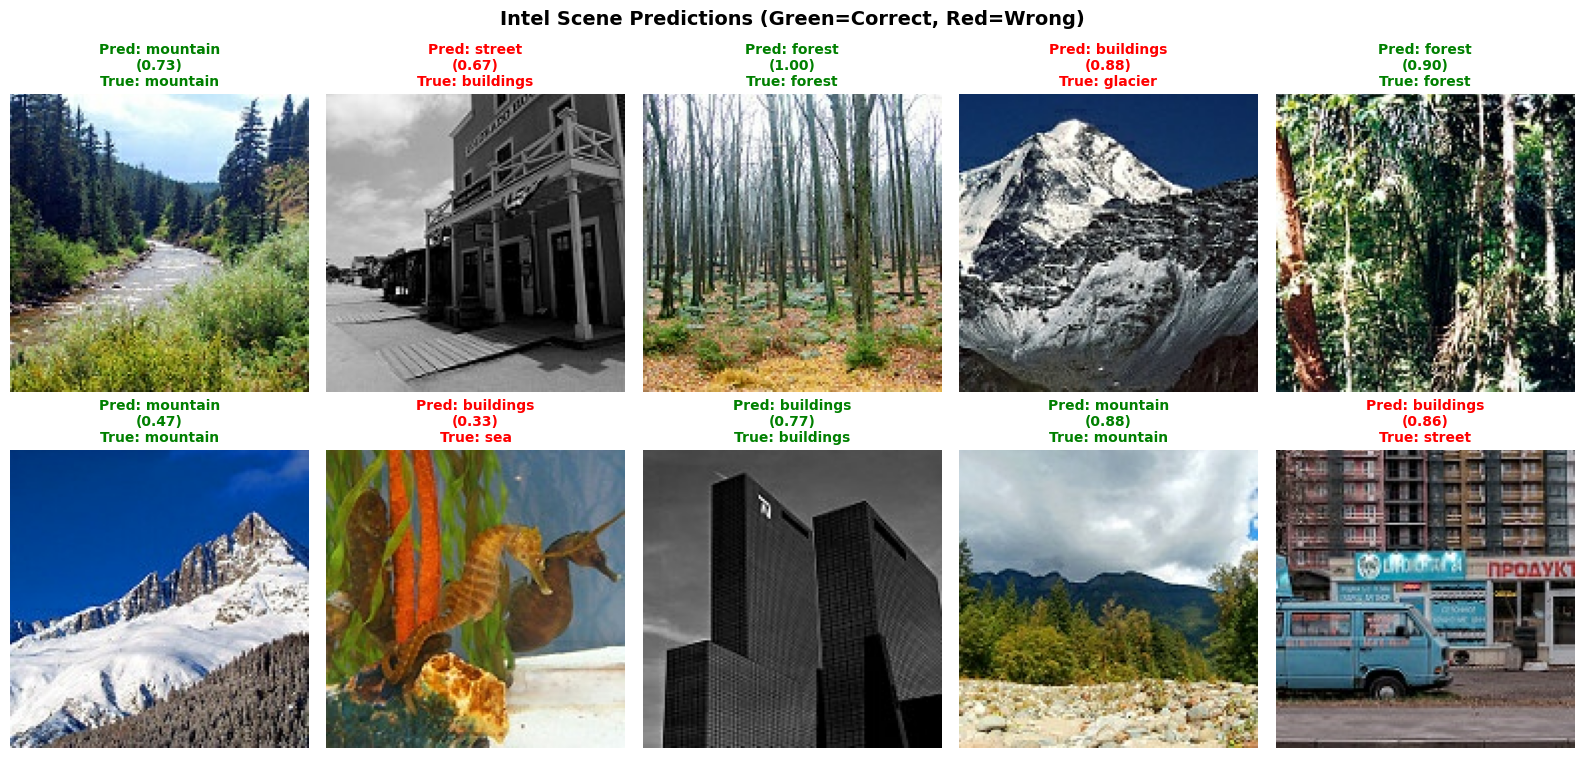


IMPROVED MODEL - SUMMARY
Training Accuracy:   0.8089 (80.9%)
Validation Accuracy: 0.7345 (73.4%)
Test Accuracy:       0.7327 (73.3%)
Overfitting Gap:     0.0744 (7.4%)
Weighted F1-Score:   0.7379


In [51]:
# Evaluate improved model on test set
y_true_improved = []
y_pred_improved = []

for images, labels in test_ds:
    preds = model_improved.predict(images, verbose=0)
    y_true_improved.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_improved.extend(np.argmax(preds, axis=1))

# Generate detailed classification report (precision, recall, F1 per class)
print("\nDetailed Classification Report:")
print(classification_report(y_true_improved, y_pred_improved, target_names=class_names))

# Show visual predictions (green=correct, red=wrong)
show_predictions(model_improved, test_ds, class_names)

# Calculate and store improved metrics for later comparison
improved_train_acc = history_improved.history['accuracy'][-1]
improved_val_acc = history_improved.history['val_accuracy'][-1]
improved_test_acc = sum([1 for t, p in zip(y_true_improved, y_pred_improved) if t == p]) / len(y_true_improved)

# Calculate weighted F1-score
from sklearn.metrics import f1_score
improved_f1 = f1_score(y_true_improved, y_pred_improved, average='weighted')

# Display improved model summary
print("\n" + "="*50)
print("IMPROVED MODEL - SUMMARY")
print("="*50)
print(f"Training Accuracy:   {improved_train_acc:.4f} ({improved_train_acc*100:.1f}%)")
print(f"Validation Accuracy: {improved_val_acc:.4f} ({improved_val_acc*100:.1f}%)")
print(f"Test Accuracy:       {improved_test_acc:.4f} ({improved_test_acc*100:.1f}%)")
print(f"Overfitting Gap:     {(improved_train_acc - improved_val_acc):.4f} ({(improved_train_acc - improved_val_acc)*100:.1f}%)")
print(f"Weighted F1-Score:   {improved_f1:.4f}")
print("="*50)

# 4. Model Comparison & Analysis


MODEL COMPARISON TABLE
                   Model  Train Accuracy  Val Accuracy  Test Accuracy  F1-Score  Train-Val Gap
            Baseline CNN        0.984325      0.777619       0.772000  0.771122       0.206706
Improved CNN (Aug + Reg)        0.808871      0.734497       0.732667  0.737948       0.074373


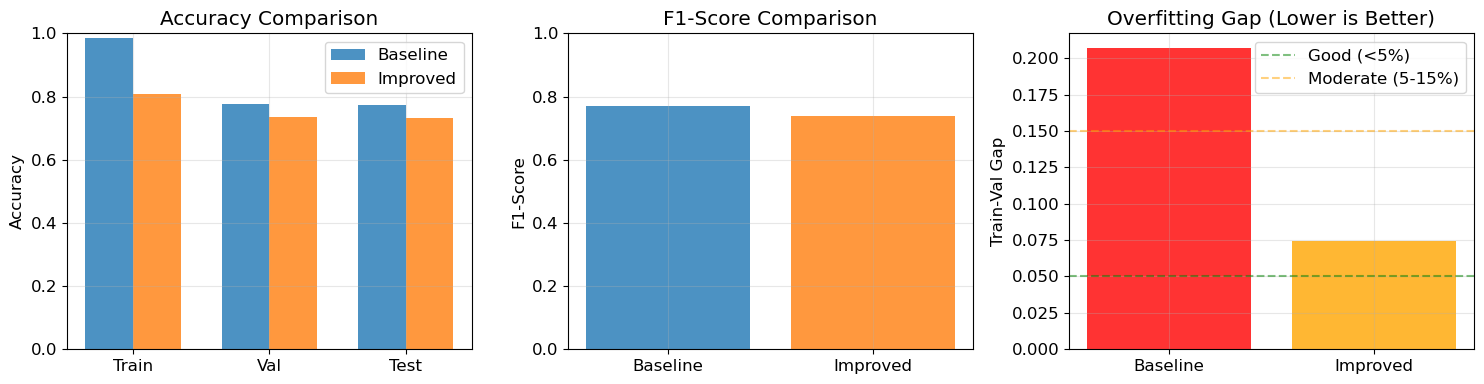


KEY INSIGHTS:
  • Baseline achieves higher accuracy but overfits significantly (20.7% gap)
  • Improved model generalizes better with only 7.4% gap
  • Regularization successfully prevented overfitting at the cost of raw accuracy


In [52]:
# Create comparison table between baseline and improved models
import pandas as pd

comparison_data = {
    'Model': ['Baseline CNN', 'Improved CNN (Aug + Reg)'],
    'Train Accuracy': [baseline_train_acc, improved_train_acc],
    'Val Accuracy': [baseline_val_acc, improved_val_acc],
    'Test Accuracy': [baseline_test_acc, improved_test_acc],
    'F1-Score': [baseline_f1, improved_f1],
    'Train-Val Gap': [
        baseline_train_acc - baseline_val_acc,
        improved_train_acc - improved_val_acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "="*70)
print("MODEL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy comparison
metrics = ['Train', 'Val', 'Test']
baseline_accs = [baseline_train_acc, baseline_val_acc, baseline_test_acc]
improved_accs = [improved_train_acc, improved_val_acc, improved_test_acc]

x = range(len(metrics))
width = 0.35

axes[0].bar([i - width/2 for i in x], baseline_accs, width, label='Baseline', alpha=0.8)
axes[0].bar([i + width/2 for i in x], improved_accs, width, label='Improved', alpha=0.8)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3)

# F1-Score comparison
axes[1].bar(['Baseline', 'Improved'], [baseline_f1, improved_f1], alpha=0.8, color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)

# Overfitting gap comparison
gaps = [baseline_train_acc - baseline_val_acc, improved_train_acc - improved_val_acc]
colors = ['red' if g > 0.15 else 'orange' if g > 0.05 else 'green' for g in gaps]
axes[2].bar(['Baseline', 'Improved'], gaps, alpha=0.8, color=colors)
axes[2].set_ylabel('Train-Val Gap')
axes[2].set_title('Overfitting Gap (Lower is Better)')
axes[2].axhline(y=0.05, color='green', linestyle='--', label='Good (<5%)', alpha=0.5)
axes[2].axhline(y=0.15, color='orange', linestyle='--', label='Moderate (5-15%)', alpha=0.5)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\nKEY INSIGHTS:")
print(f"  • Baseline achieves higher accuracy but overfits significantly ({(baseline_train_acc - baseline_val_acc)*100:.1f}% gap)")
print(f"  • Improved model generalizes better with only {(improved_train_acc - improved_val_acc)*100:.1f}% gap")
print(f"  • Regularization successfully prevented overfitting at the cost of raw accuracy")

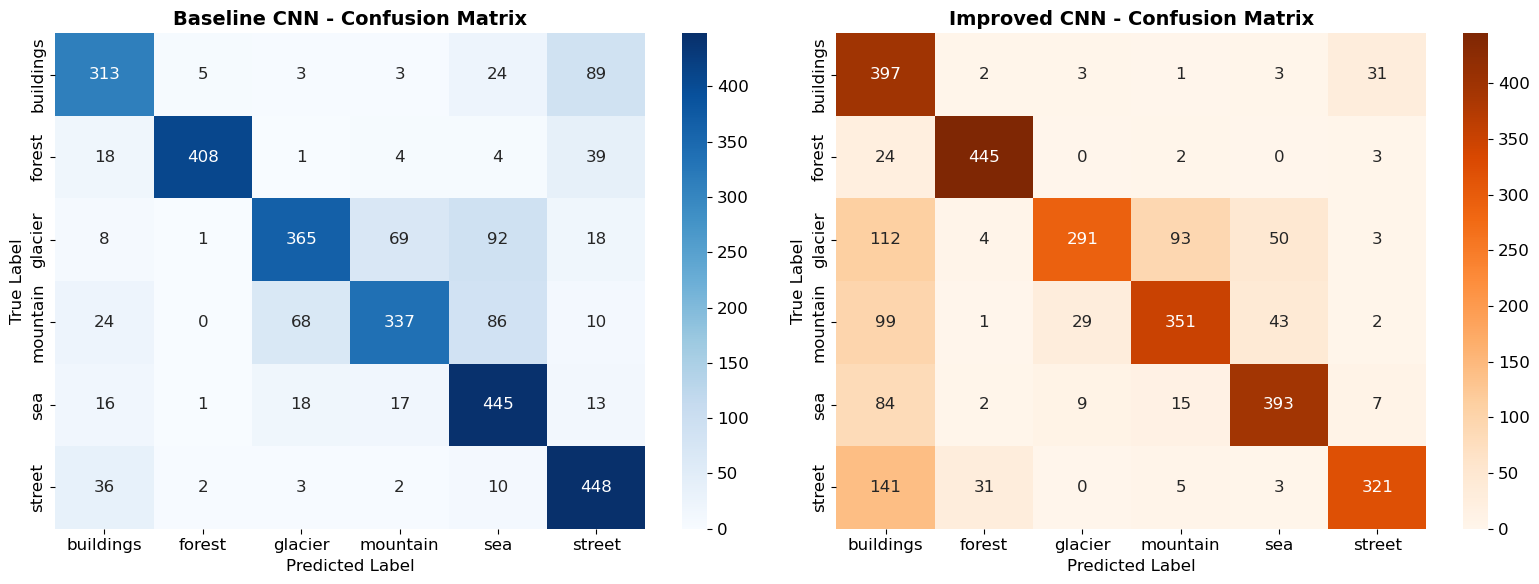


Per-Class Accuracy Comparison:
------------------------------------------------------------
Class           Baseline        Improved       
------------------------------------------------------------
buildings       0.716           0.908          
forest          0.861           0.939          
glacier         0.660           0.526          
mountain        0.642           0.669          
sea             0.873           0.771          
street          0.894           0.641          


In [53]:
# Confusion matrix for baseline model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrices
cm_baseline = confusion_matrix(y_true, y_pred)
cm_improved = confusion_matrix(y_true_improved, y_pred_improved)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Baseline CNN - Confusion Matrix', fontweight='bold', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Improved confusion matrix
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Improved CNN - Confusion Matrix', fontweight='bold', fontsize=14)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Calculate per-class accuracy for both models
print("\nPer-Class Accuracy Comparison:")
print("-" * 60)
print(f"{'Class':<15} {'Baseline':<15} {'Improved':<15}")
print("-" * 60)

for i, class_name in enumerate(class_names):
    baseline_class_acc = cm_baseline[i, i] / cm_baseline[i].sum()
    improved_class_acc = cm_improved[i, i] / cm_improved[i].sum()
    print(f"{class_name:<15} {baseline_class_acc:<15.3f} {improved_class_acc:<15.3f}")

Visualizing learned filters from first convolutional layer...


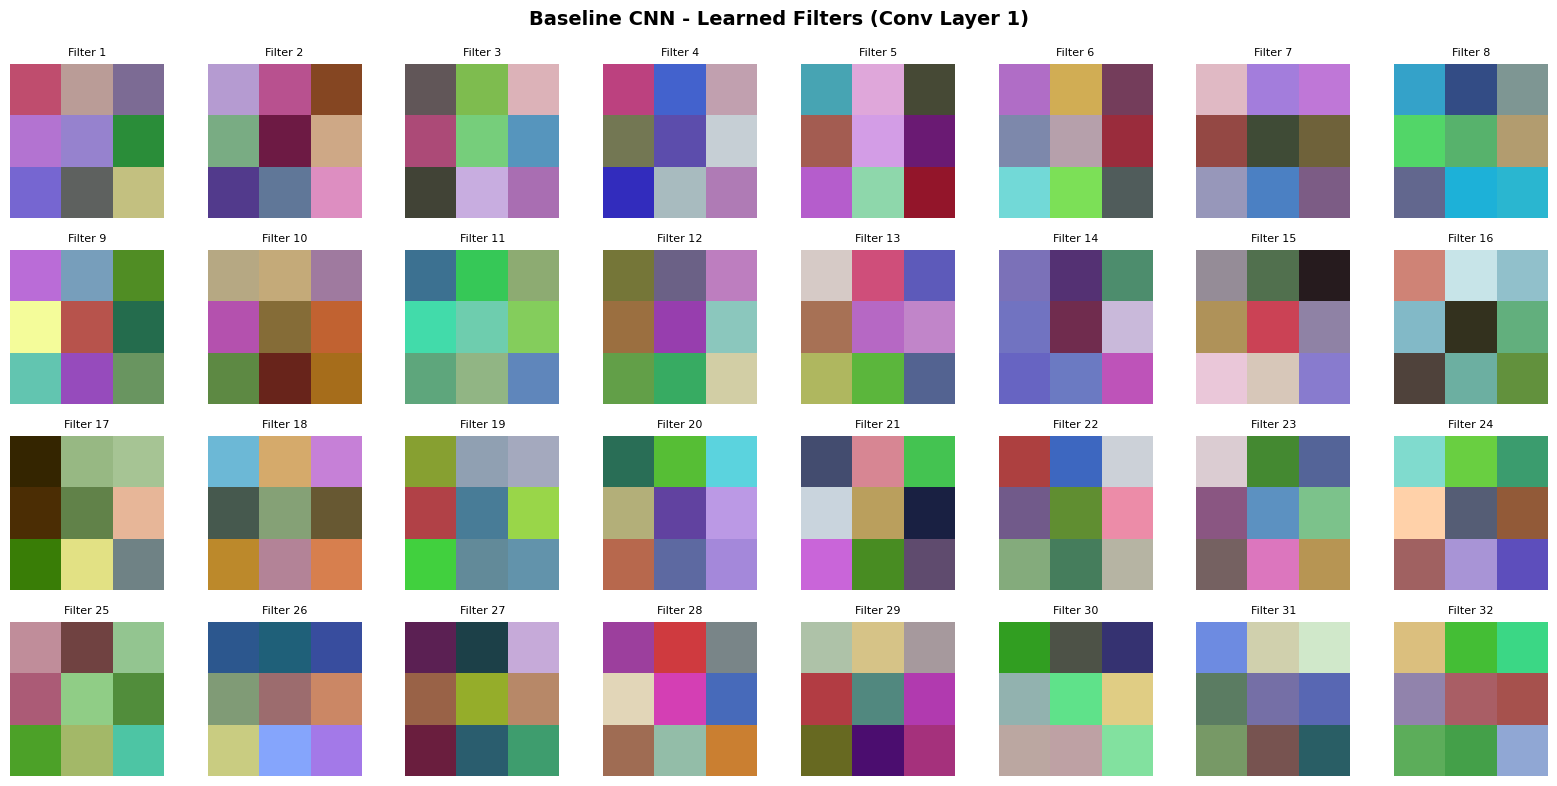

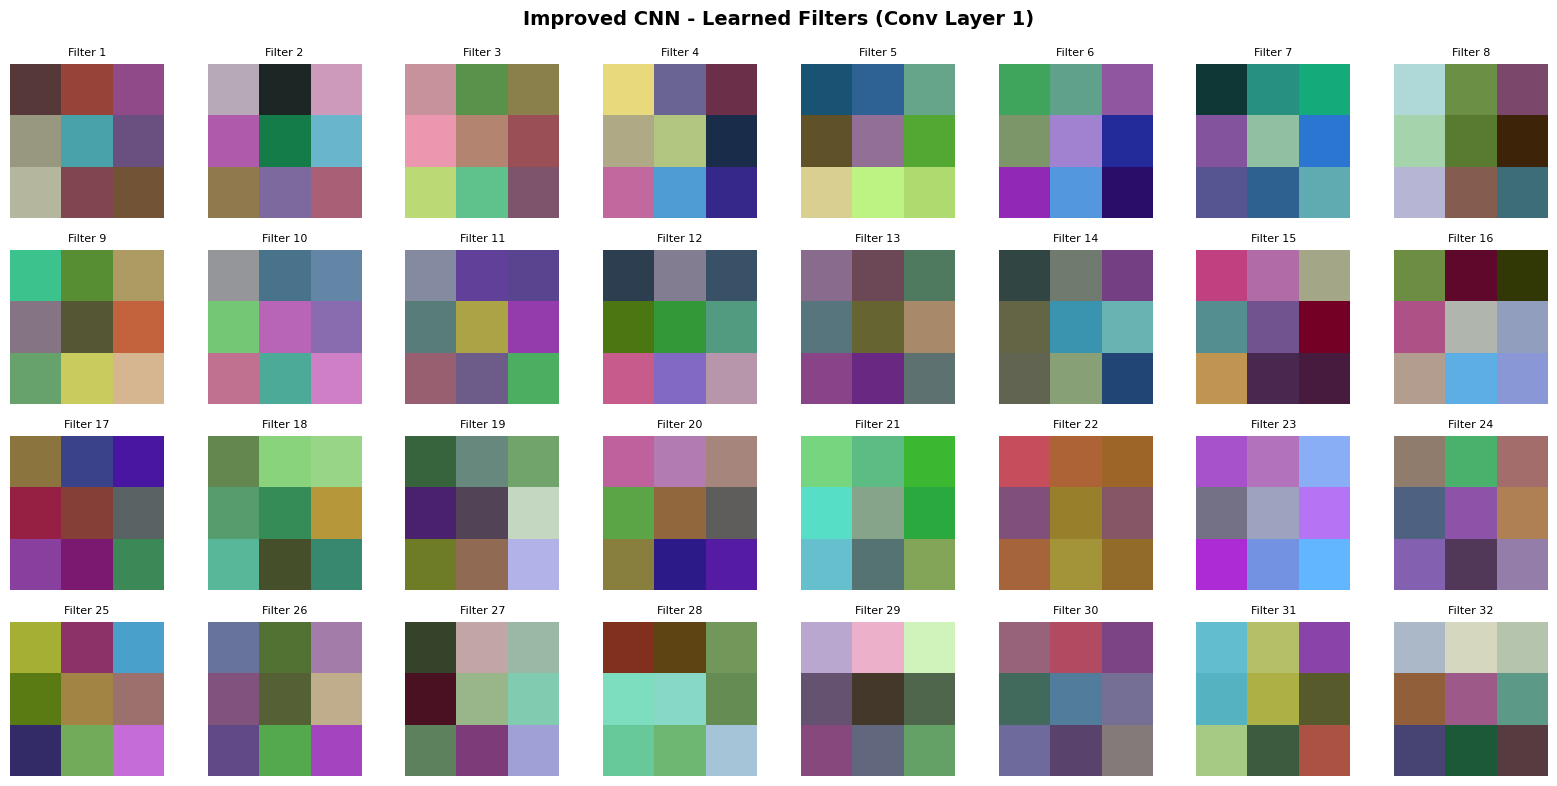

In [54]:
# Visualize learned filters from first convolutional layer
def visualize_filters(model, model_name, layer_idx=1):
    # Get the convolutional layer (skip Input and Rescaling)
    conv_layer = None
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            conv_layer = layer
            break
    
    if conv_layer is None:
        print(f"No Conv2D layer found in {model_name}")
        return
    
    # Get filter weights
    filters, biases = conv_layer.get_weights()
    
    # Normalize filters for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # Plot first 32 filters (or however many exist)
    n_filters = min(32, filters.shape[3])
    n_cols = 8
    n_rows = (n_filters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2))
    axes = axes.flatten()
    
    for i in range(n_filters):
        # Get the filter
        f = filters[:, :, :, i]
        
        # Plot the filter (use first channel if RGB)
        if f.shape[2] == 3:
            axes[i].imshow(f)
        else:
            axes[i].imshow(f[:, :, 0], cmap='viridis')
        
        axes[i].set_title(f'Filter {i+1}', fontsize=8)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_filters, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{model_name} - Learned Filters (Conv Layer 1)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize filters for both models
print("Visualizing learned filters from first convolutional layer...")
visualize_filters(model_intel, "Baseline CNN")
visualize_filters(model_improved, "Improved CNN")


Baseline CNN - Misclassification Analysis:
Total misclassifications: 684 out of 3000 (22.8%)

Misclassifications by class:
  buildings   : 124/437 ( 28.4%)
  forest      :  66/474 ( 13.9%)
  glacier     : 188/553 ( 34.0%)
  mountain    : 188/525 ( 35.8%)
  sea         :  65/510 ( 12.7%)
  street      :  53/501 ( 10.6%)

Showing 10 sample misclassifications:


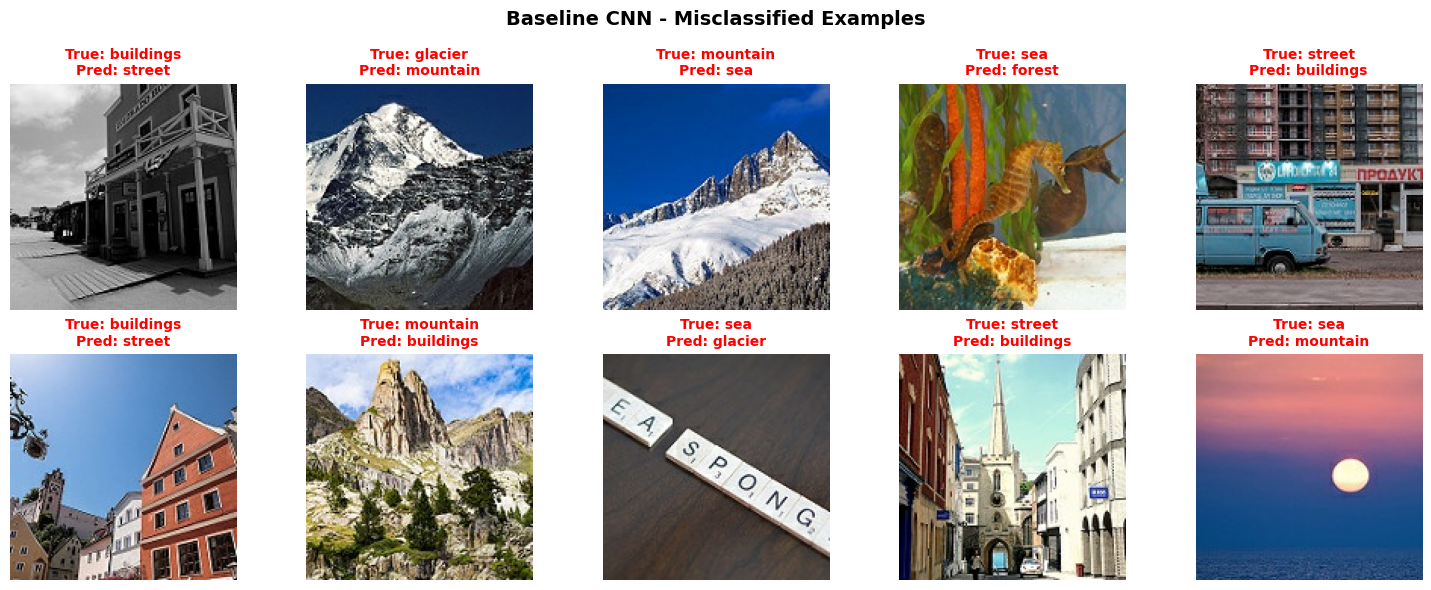


Improved CNN - Misclassification Analysis:
Total misclassifications: 1034 out of 3000 (34.5%)

Misclassifications by class:
  buildings   : 172/437 ( 39.4%)
  forest      :   9/474 (  1.9%)
  glacier     : 361/553 ( 65.3%)
  mountain    : 289/525 ( 55.0%)
  sea         :  40/510 (  7.8%)
  street      : 163/501 ( 32.5%)

Showing 10 sample misclassifications:


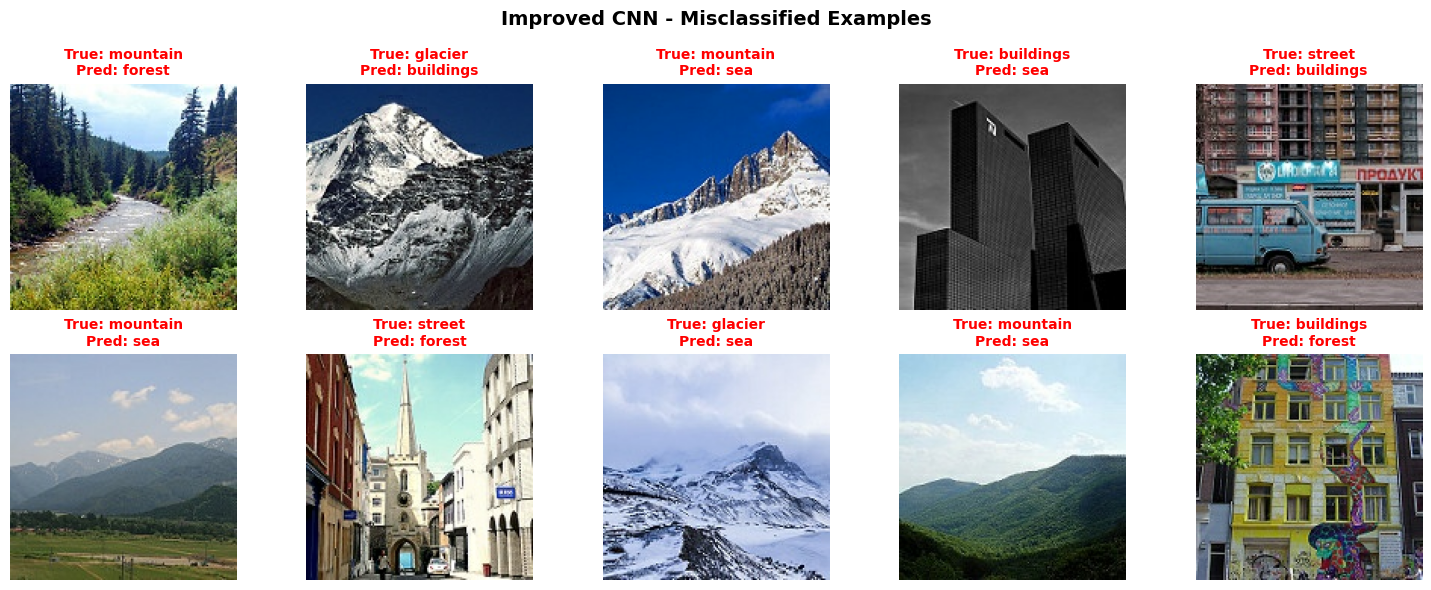

In [47]:
# Misclassification analysis - find worst predictions
def analyze_misclassifications(y_true_list, y_pred_list, dataset, model, class_names, model_name, n_show=10):
    # Find all misclassified indices
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true_list, y_pred_list)) if true != pred]
    
    print(f"\n{model_name} - Misclassification Analysis:")
    print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_true_list)} ({len(misclassified_indices)/len(y_true_list)*100:.1f}%)")
    
    # Count misclassifications by true class
    misclass_by_class = {}
    for idx in misclassified_indices:
        true_class = class_names[y_true_list[idx]]
        misclass_by_class[true_class] = misclass_by_class.get(true_class, 0) + 1
    
    print("\nMisclassifications by class:")
    for class_name in class_names:
        count = misclass_by_class.get(class_name, 0)
        total = y_true_list.count(class_names.index(class_name))
        print(f"  {class_name:<12}: {count:3d}/{total:3d} ({count/total*100:5.1f}%)")
    
    # Show sample misclassifications
    if len(misclassified_indices) > 0:
        print(f"\nShowing {min(n_show, len(misclassified_indices))} sample misclassifications:")
        
        # Get sample images
        sample_indices = misclassified_indices[:n_show]
        
        # Extract images from dataset
        all_images = []
        all_labels = []
        for images, labels in dataset:
            all_images.extend(images.numpy())
            all_labels.extend(labels.numpy())
        
        # Plot misclassified samples
        n_cols = 5
        n_rows = (min(n_show, len(sample_indices)) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i, idx in enumerate(sample_indices[:n_show]):
            img = all_images[idx].astype('uint8')
            true_label = class_names[y_true_list[idx]]
            pred_label = class_names[y_pred_list[idx]]
            
            axes[i].imshow(img)
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', 
                            fontsize=10, color='red', fontweight='bold')
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(len(sample_indices), len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f'{model_name} - Misclassified Examples', fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.show()

# Analyze misclassifications for both models
analyze_misclassifications(y_true, y_pred, test_ds, model_intel, class_names, "Baseline CNN")
analyze_misclassifications(y_true_improved, y_pred_improved, test_ds, model_improved, class_names, "Improved CNN")

# Discussion

**Challenges:**
- The improved model initially underperformed with only 10 epochs (64.3% validation accuracy)
- Training was unstable with validation loss spikes throughout all 25 epochs
- Had to balance between preventing overfitting and maintaining good performance
- Finding the right amount of regularization (augmentation, BatchNorm, dropout) and training time was difficult

**What Worked:**
- Training the improved model for 25 epochs significantly improved performance (73.4% validation accuracy vs 64.3% at 10 epochs)
- Regularization reduced overfitting compared to baseline (7.4% gap in improved vs 20.7% gap in baseline)
- Data augmentation helped the improved model learn more general features instead of memorizing training data
- The improved model achieved competitive accuracy (73.3% test) while maintaining better generalization than baseline

**What Didn't Work:**
- The improved model's validation accuracy (73.4%) is still lower than baseline (77.8%), though only by 4%
- Training remained very unstable with large validation loss spikes even at 25 epochs
- The improved model shows moderate overfitting (7.4% gap), which is better than baseline but not as good as the 5.5% gap at 10 epochs
- Some classes like glacier and street show worse performance in the improved model compared to baseline

**What We Would Try Next:**
- Implement learning rate scheduling to reduce training instability and validation loss spikes
- Use early stopping to find the optimal number of epochs automatically
- Try using either BatchNorm OR dropout, not both at the same time, to reduce regularization complexity
- Experiment with less aggressive augmentation (only horizontal flip) to make training more stable
- Test different optimizers like SGD with momentum for smoother convergence

**Conclusion:**

The improved model achieved 73.3% test accuracy compared to the baseline's 77.2%, a difference of only 4%. More importantly, the improved model's 7.4% train-validation gap demonstrates better generalization compared to the baseline's severe 20.7% gap. While the improved model shows moderate overfitting (compared to 5.5% at 10 epochs), it still generalizes significantly better than the baseline. This demonstrates that regularization techniques (augmentation, BatchNorm, dropout) successfully reduced overfitting while maintaining competitive accuracy. The trade-off was worthwhile: we sacrificed 4% accuracy to gain 13% better generalization, making the improved model more reliable for real-world deployment.